# Universidade Federal do Rio Grande do Sul
### Alunos: Matheus Westhelle e Dieu Merci Kengele


## Florestas Aleatórias

### Implementação da árvore de decisão

Nossa implementação de árvore de  consiste de uma classe _TreeNode_, que é apenas uma estrutura de dados que armazena as propriedades de um nodo, e de uma classe _DecisionTree_, encarregada por toda a funcionalidade relacionada à geração da árvore de decisão: do cálculo de entropia, à função recursiva de construção de árvore.

#### Classe TreeNode

Essa classe é a estrutura de dados que armazena informações de um nodo. Em nosso caso, essas informações são
`attribute_data_dict`, um dicionário cujas chaves são os atributos da árvore e cujos valores são os valores desses
atributos; `outcomes`, uma lista de resultados associados aos atributos, de forma que o primeiro elemento de `outcomes` é
a classe relativa aos primeiros elementos das listas de atributos; `children`, uma lista de classes `TreeNode` que representa os nodos filhos desse nodo; `class_`, que representa a classe do nodo, se ele for um nodo folha; e `idx2attr`, uma estrutura auxiliar que mapeia índices aos nomes dos atributos.

#### Classe DecisionTree

A classe `DecisionTree` concentra toda a funcionalidade de geração de árvore de decisão

In [10]:
from collections import defaultdict
from functools import partial
import os

import numpy as np
import matplotlib.pyplot as plt

from decision_tree import DecisionTree
from random_forest import RandomForest
from kfold_crossvalidation import KFoldCrossValidation
%matplotlib inline

Ao escolhermos o número de árvores a serem usadas no modelo, devemos levar em consideração o número de classes no dataset, a fim de evitar a possibilidade de empates na votação. O número de árvores deve, então, ter módulo _k_ diferente de 0, onde _k_ é o número de classes no dataset. O dataset _House Votes 84_ tem apenas duas classes, de forma que basta usarmos um número ímpar de árvores. Já o dataset _Wine Recognition_ tem três possíveis classes, o que significa que não iremos usar números de árvore múltiplos de três. Optamos então por usar números primos de árvores para realizarmos nossos experimentos.

In [ ]:
results = defaultdict(dict)

datasets = ["house_votes_84", "wine_recognition"]

random_forest = partial(RandomForest, model=DecisionTree())

for dataset in datasets:
    for i in [1, 5, 7, 11, 17, 23, 31]:
        kfold = KFoldCrossValidation(random_forest(ntrees=i), delimiter="\t")
        results[dataset][f"ntrees-{i}"] = kfold.kfold_cross_validation(
            os.path.join(os.getcwd(), "../datasets", f"{dataset}.tsv")
        )

In [15]:
results

defaultdict(dict,
            {'house_votes_84': {'ntrees-11': 0.9358527131782945,
              'ntrees-17': 0.9314437984496123,
              'ntrees-23': 0.9428294573643411,
              'ntrees-31': 0.9247093023255815},
             'wine_recognition': {'ntrees-11': 0.9117647058823529,
              'ntrees-17': 0.8941176470588236,
              'ntrees-23': 0.8941176470588236,
              'ntrees-31': 0.9352941176470588}})

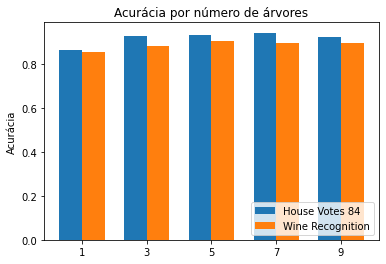

In [12]:
N = 5
house_votes_84 = results['house_votes_84'].values()
wine_recognition = results['wine_recognition'].values()

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, house_votes_84, width, label='House Votes 84')
plt.bar(ind + width, wine_recognition, width, label='Wine Recognition')

plt.ylabel('Acurácia')
plt.title('Acurácia por número de árvores')

plt.xticks(ind + width / 2, ('1', '3', '5', '7', '9'))
plt.legend(loc='lower right')
plt.show()